In [6]:
# Cell 1
!pip install -q scikit-learn imbalanced-learn transformers torch sentencepiece joblib seaborn matplotlib


In [7]:
# Cell 2
import os, re, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from transformers import pipeline as hf_pipeline
import joblib


In [8]:
# Cell 3.1

DATA_PATH = "icmla_metadata.csv"

# Step 1: Load dataset safely with encoding fallback
for enc in ("utf-8", "latin-1", "cp1252"):
    try:
        df = pd.read_csv(DATA_PATH, encoding=enc)
        print(f"Loaded {DATA_PATH} with encoding {enc}")
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

print("Columns in dataset:", df.columns.tolist())
print("Number of rows:", len(df))

# Cell 3.2
def build_text(row):
    parts = []
    if pd.notna(row.get('title')) and str(row['title']).strip():
        parts.append(str(row['title']))
    if pd.notna(row.get('abstract')) and str(row['abstract']).strip():
        parts.append(str(row['abstract']))
    return " ".join(parts).strip()

df['final_text'] = df.apply(build_text, axis=1)

# Cell 3.3
before = len(df)
df = df[df['final_text'].str.strip().astype(bool)].reset_index(drop=True)
after = len(df)

print(f"Dropped {before - after} empty rows → final size: {after}")
df[['title','abstract','final_text']].head(5)


Loaded icmla_metadata.csv with encoding latin-1
Columns in dataset: ['paper_id', 'title', 'keywords', 'abstract', 'session', 'year']
Number of rows: 448
Dropped 0 empty rows → final size: 448


,title,abstract,final_text
0,Ensemble Statistical and Heuristic Models for ...,Statistical word alignment models need large a...,Ensemble Statistical and Heuristic Models for ...
1,Improving Spectral Learning by Using Multiple ...,Spectral learning algorithms learn an unknown ...,Improving Spectral Learning by Using Multiple ...
2,Applying Swarm Ensemble Clustering Technique f...,Number of defects remaining in a system provid...,Applying Swarm Ensemble Clustering Technique f...
3,Reducing the Effects of Detrimental Instances,Not all instances in a data set are equally be...,Reducing the Effects of Detrimental Instances ...
4,Concept Drift Awareness in Twitter Streams,Learning in non-stationary environments is not...,Concept Drift Awareness in Twitter Streams Lea...


In [9]:
# Cell 4
df['session'] = df['session'].astype(str).str.strip()

MIN_FREQ = 8   # change depending on dataset
counts = df['session'].value_counts()
keep = counts[counts >= MIN_FREQ].index.tolist()

df = df[df['session'].isin(keep)].reset_index(drop=True)
print("Sessions kept:", len(keep))
print(df['session'].value_counts().head(20))


Sessions kept: 11
session
Machine Learning in Energy Applications                               20
Machine Learning for Predictive Models in Engineering Applications    19
Machine Learning Algorithms Systems and Applications                  16
Machine Learning in Information and System Security Issues            15
Machine Learning Algorithms, Systems and Applications Workshop        11
Machine Learning Applications in Education                            11
Ensemble Methods                                                       8
Deep Learning                                                          8
Machine Learning Applications I                                        8
Time Series                                                            8
Machine Learning Applications III                                      8
Name: count, dtype: int64


In [10]:
# Cell 5
X = df['final_text'].values
y = df['session'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 105 Test size: 27


In [11]:
# Cell 6
use_oversample = True  # change to False if oversampling slows things

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=2)
clf = LogisticRegression(solver='saga', max_iter=5000, class_weight='balanced', random_state=42)

if use_oversample:
    ros = RandomOverSampler(random_state=42)
    pipe = ImbPipeline([
        ('tfidf', tfidf),
        ('ros', ros),
        ('clf', clf)
    ])
else:
    pipe = Pipeline([
        ('tfidf', tfidf),
        ('clf', clf)
    ])


In [12]:
# Cell 7
param_grid = {
    'tfidf__max_features': [2000, 5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1.0, 5.0],
}


In [13]:
# Cell 8
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='f1_macro', n_jobs=-1, verbose=1)

outer_scores = []
fold_reports = []

fold = 0
for train_idx, test_idx in outer_cv.split(X, y):
    fold += 1
    print(f"\n Outer fold number {fold} ")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    grid.fit(X_tr, y_tr)
    best = grid.best_estimator_
    y_pred = best.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average='macro')
    print("Accuracy:", acc, "Macro F1:", f1m)
    print("Best params:", grid.best_params_)

    outer_scores.append({'fold': fold, 'accuracy': acc, 'macro_f1': f1m})
    fold_reports.append({'fold': fold, 'report': classification_report(y_te, y_pred, zero_division=0)})



 Outer fold number 1 
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Accuracy: 0.4074074074074074 Macro F1: 0.2818181818181818
Best params: {'clf__C': 1.0, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1)}

 Outer fold number 2 
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Accuracy: 0.4444444444444444 Macro F1: 0.35454545454545455
Best params: {'clf__C': 0.1, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1)}

 Outer fold number 3 
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Accuracy: 0.5 Macro F1: 0.5136363636363637
Best params: {'clf__C': 1.0, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1)}

 Outer fold number 4 
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Accuracy: 0.46153846153846156 Macro F1: 0.34836829836829836
Best params: {'clf__C': 0.1, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2)}

 Outer fold number 5 
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Accuracy

In [14]:
# Cell 9
accs = [s['accuracy'] for s in outer_scores]
f1s = [s['macro_f1'] for s in outer_scores]

print("Nested CV results:")
print("Accuracy mean ± std:", np.mean(accs), np.std(accs))
print("Macro F1 mean ± std:", np.mean(f1s), np.std(f1s))


Nested CV results:
Accuracy mean ± std: 0.4242165242165242 0.06543037583342985
Macro F1 mean ± std: 0.35517149517149516 0.08552548276578445


In [16]:
# Cell 10
best_overall = grid.best_estimator_
best_overall.fit(X, y)

joblib.dump(best_overall, "best_session_classifier.joblib")
print("Saved model.")


Saved model.


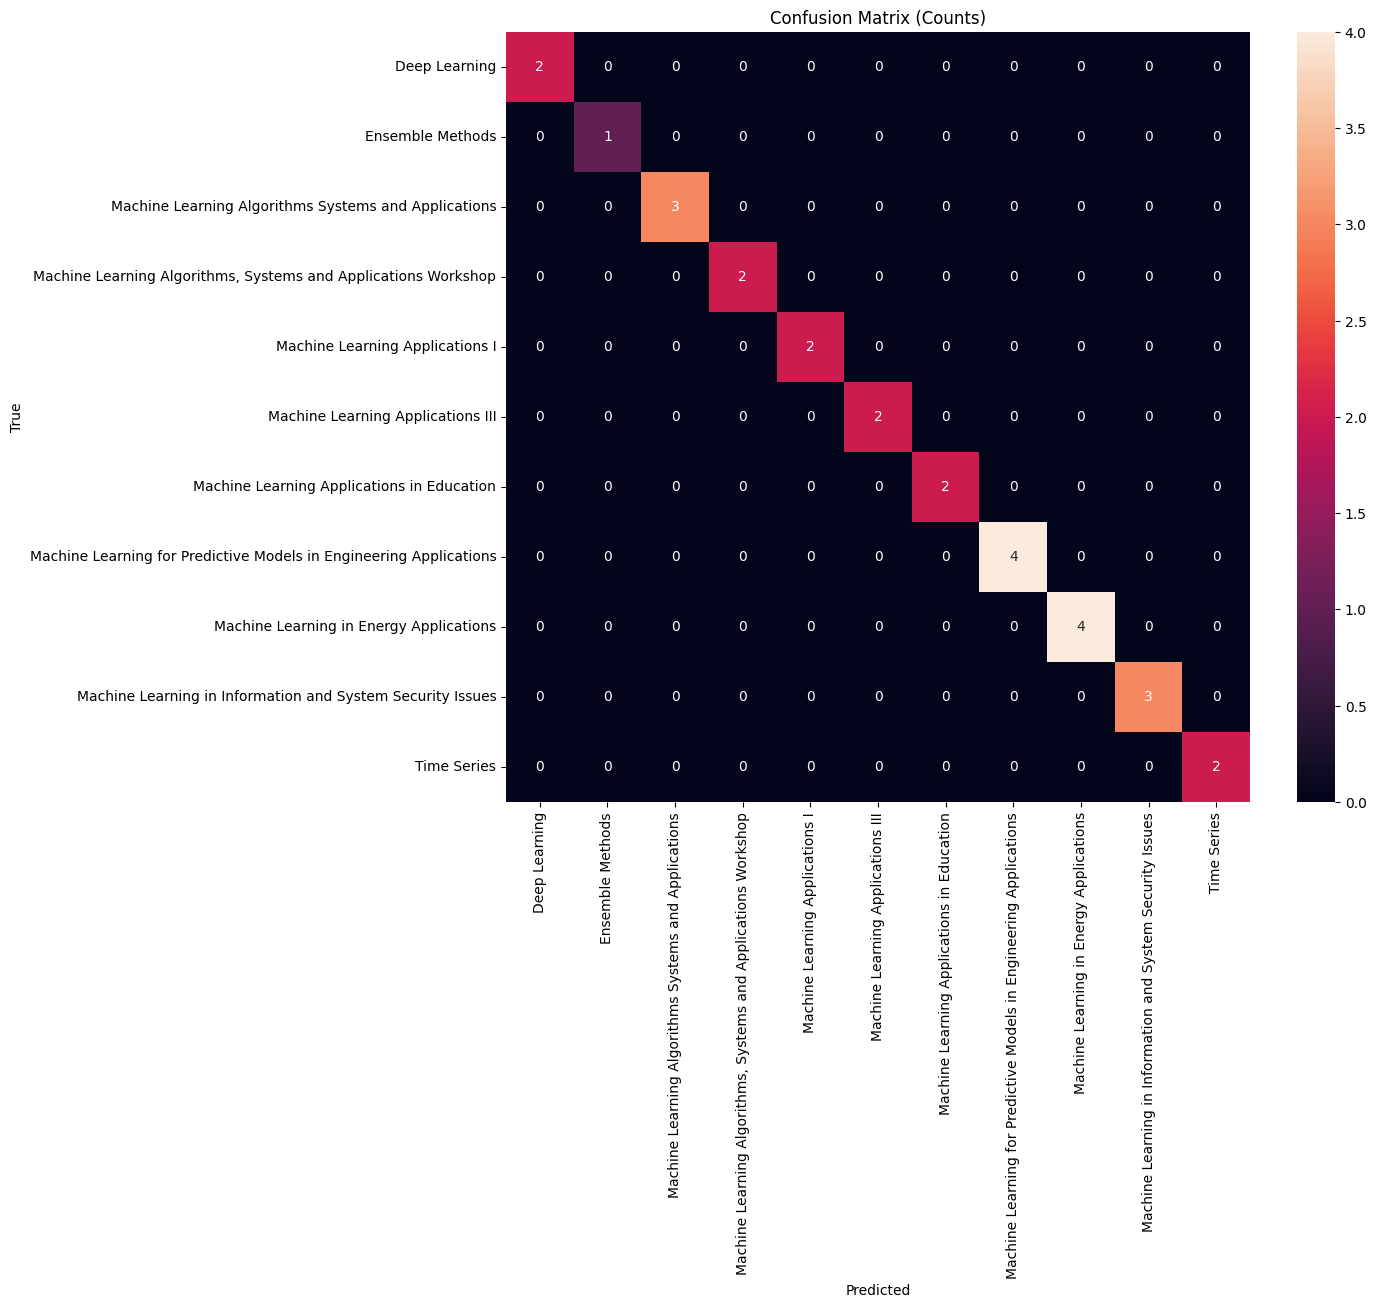

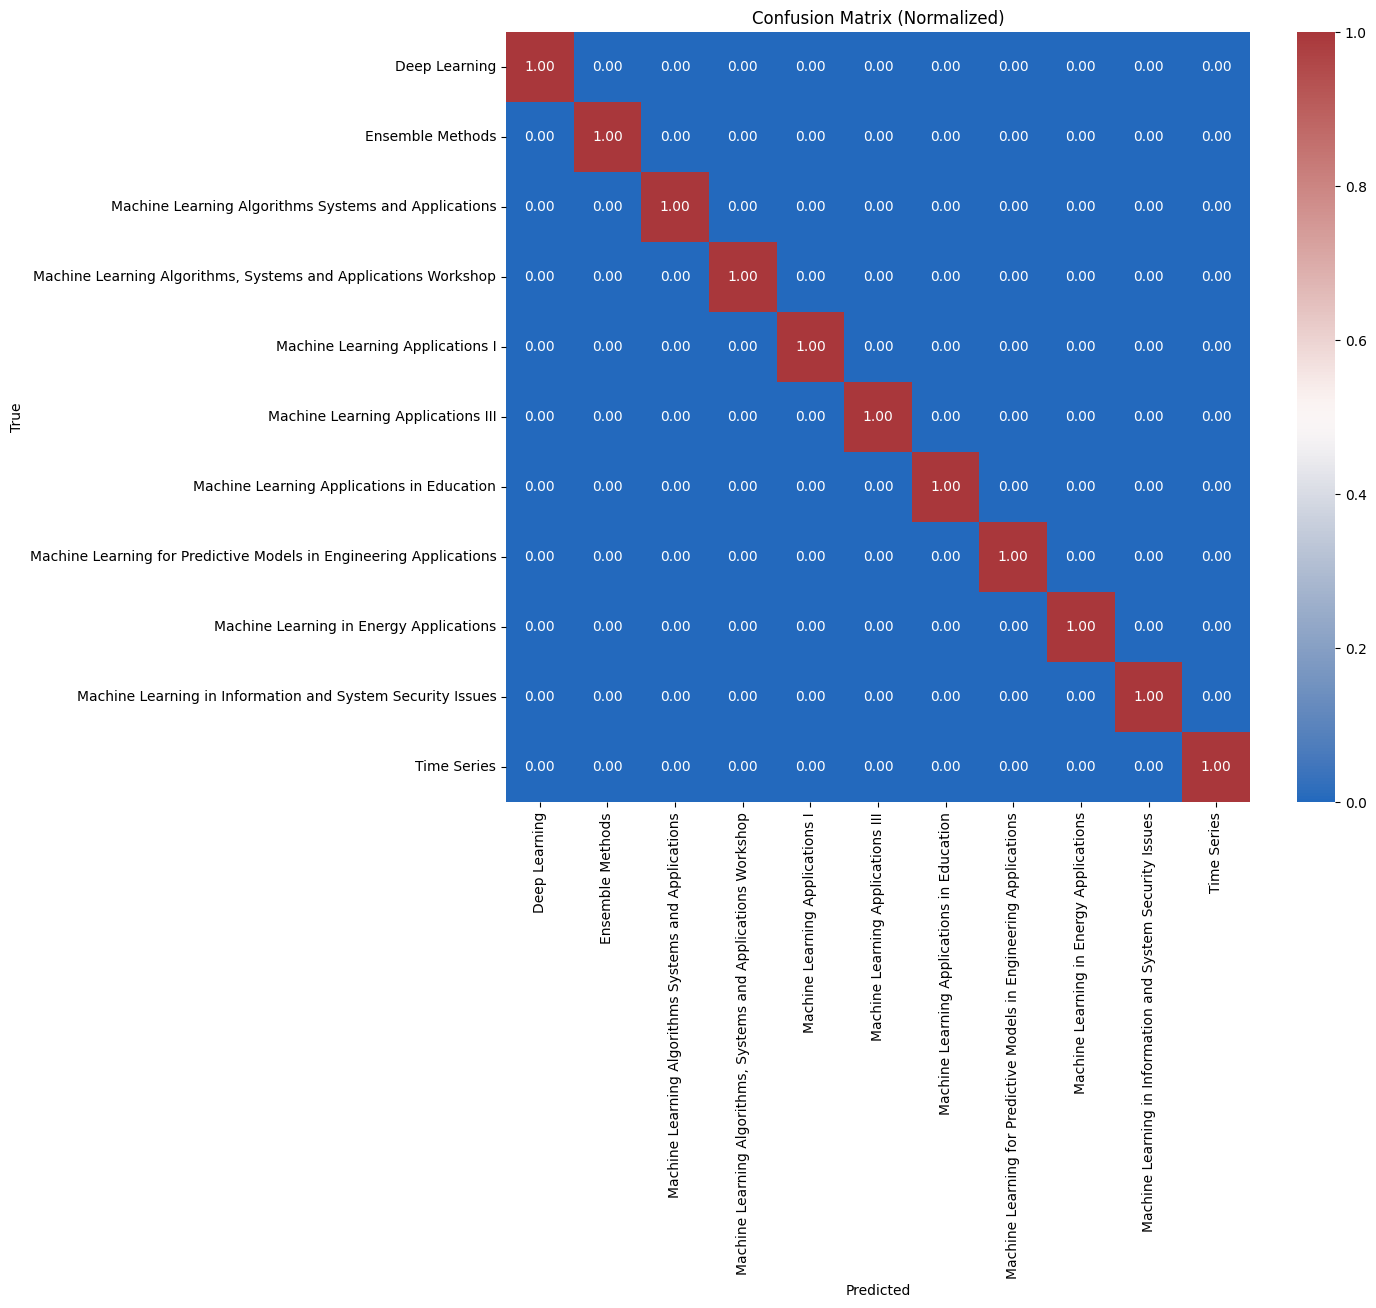

                                                                    precision    recall  f1-score   support

                                                     Deep Learning       1.00      1.00      1.00         2
                                                  Ensemble Methods       1.00      1.00      1.00         1
              Machine Learning Algorithms Systems and Applications       1.00      1.00      1.00         3
    Machine Learning Algorithms, Systems and Applications Workshop       1.00      1.00      1.00         2
                                   Machine Learning Applications I       1.00      1.00      1.00         2
                                 Machine Learning Applications III       1.00      1.00      1.00         2
                        Machine Learning Applications in Education       1.00      1.00      1.00         2
Machine Learning for Predictive Models in Engineering Applications       1.00      1.00      1.00         4
                           

In [17]:
# Cell 11
y_pred = best_overall.predict(X_test)
labels = sorted(np.unique(y_test))

cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(np.round(cm_norm,2), annot=True, fmt=".2f", cmap="vlag",
            xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred, zero_division=0))


In [18]:
# Cell 12
METH_KEYWORDS = {
    "experimental": ["experiment", "evaluated", "dataset", "measurement"],
    "simulation": ["simulation", "simulated", "simulate"],
    "survey": ["survey", "review", "systematic review"],
    "theoretical": ["theorem", "proof", "derivation", "analysis"],
    "case study": ["case study", "deployment", "application"],
    "qualitative": ["interview", "qualitative", "focus group"],
    "quantitative": ["statistical", "quantitative", "regression", "anova"],
}

def rule_methodology(text):
    if pd.isna(text) or not str(text).strip():
        return []
    t = str(text).lower()
    found = [lab for lab, kws in METH_KEYWORDS.items() if any(kw in t for kw in kws)]
    return found

df['method_by_rule'] = df['abstract'].map(rule_methodology)
print("Rule-based sample:")
print(df[['title','method_by_rule']].head(10))


Rule-based sample:
                                               title  \
0  Ensemble Statistical and Heuristic Models for ...   
1  Improving Spectral Learning by Using Multiple ...   
2  Applying Swarm Ensemble Clustering Technique f...   
3      Reducing the Effects of Detrimental Instances   
4         Concept Drift Awareness in Twitter Streams   
5  Next Generation Application-Layer DDoS Defence...   
6           TSD: Detecting Sybil Accounts in Twitter   
7  An Intelligent Technique for Detecting Malicio...   
8  Age Estimation from Fingerprints: Examination ...   
9  Diagnosis using incomplete model in fuzzy disc...   

                 method_by_rule  
0  [experimental, quantitative]  
1                            []  
2                 [theoretical]  
3                            []  
4                  [simulation]  
5    [experimental, case study]  
6        [experimental, survey]  
7    [experimental, case study]  
8                            []  
9                       

In [19]:
# Cell 13 (updated with progress bar + timing)
from tqdm import tqdm
import time

to_fallback = df[df['method_by_rule'].apply(lambda l: len(l) == 0)]
print("Abstracts needing zero-shot:", len(to_fallback))

fallback_preds = {}

if len(to_fallback) > 0:
    device = 0 if (os.environ.get("CUDA_VISIBLE_DEVICES") or False) else -1
    zclf = hf_pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

    candidate_labels = list(METH_KEYWORDS.keys())
    batch_size = 16

    start_time = time.time()
    for i in tqdm(range(0, len(to_fallback), batch_size), desc="Zero-shot batches"):
        batch = to_fallback.iloc[i:i+batch_size]
        texts = batch['abstract'].astype(str).tolist()

        outs = zclf(texts, candidate_labels, multi_label=True)

        for idx_local, out in enumerate(outs):
            labs = [lab for lab, sc in zip(out['labels'], out['scores']) if sc >= 0.25]
            if not labs:
                labs = [out['labels'][0]]
            fallback_preds[batch.index[idx_local]] = labs

    elapsed = time.time() - start_time
    print(f"Zero-shot classification completed in {elapsed:.2f} seconds.")

    # Write results into df
    df['method_by_zero_shot'] = None
    for idx, labs in fallback_preds.items():
        df.at[idx, 'method_by_zero_shot'] = labs


Abstracts needing zero-shot: 36


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Zero-shot batches: 100%|██████████| 3/3 [12:11<00:00, 243.71s/it]

Zero-shot classification completed in 731.13 seconds.


In [21]:
# Cell 14
def combine_methods(row):
    if isinstance(row['method_by_rule'], list) and row['method_by_rule']:
        return row['method_by_rule']
    if row.get('method_by_zero_shot') is not None:
        return row['method_by_zero_shot']
    return ["unknown"]

df['methodologies_final'] = df.apply(combine_methods, axis=1)
df[['title','session','methodologies_final']].head(15)

# Save final dataframe with predictions to CSV (readable in Excel/Sheets)
output_csv = "icmla_with_predictions.csv"
df.to_csv(output_csv, index=False, encoding="utf-8")
print(f"Saved full dataset with predictions to {output_csv}")



Saved full dataset with predictions to icmla_with_predictions.csv
